In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Function to fetch messages from a single page
def fetch_posts_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find all posts on the page
    posts = soup.find_all("div", class_="Message")
    dates = soup.find_all("span", class_="DateCreated")
    
    data = []
    
    # Loop through each post and extract the date and message
    for post, date in zip(posts, dates):
        message_text = post.get_text(strip=True)
        date_text = date.get_text(strip=True)
        data.append([date_text, message_text])
    
    return data

# Function to fetch posts from multiple pages
def fetch_all_posts(base_url, num_pages):
    all_data = []
    
    for i in range(1, num_pages + 1):
        page_url = f"{base_url}/p{i}"
        print(f"Fetching page {i}...")
        page_data = fetch_posts_from_page(page_url)
        all_data.extend(page_data)
        
        # Sleep to avoid overwhelming the server
        time.sleep(2)
    
    return all_data

# Base URL for the forum thread
base_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"

# Number of pages to scrape
num_pages = 100  # Adjust this number based on how many posts you want

# Fetch the posts
all_posts = fetch_all_posts(base_url, num_pages)

# Convert to DataFrame
df = pd.DataFrame(all_posts, columns=["Date", "Message"])

# Save to CSV
df.to_csv("edmunds_forum_posts_16_sep.csv", index=False)

print("Scraping complete. Data saved to 'edmunds_forum_posts.csv'.")


In [1]:
import pandas as pd
df = pd.read_csv('edmunds_forum_posts_16_sep.csv')

In [3]:
df.columns = ['date','message']

In [5]:
df.head()

,date,message
0,March 2002,Entry level performance luxury sedans are a ho...
1,March 2002,I personally think that with a few tweaks the ...
2,March 2002,I am debating a new purchase and these two are...
3,March 2002,"Great handling, RWD, excellent engine and the ..."
4,March 2002,And no manual tranny. That may not matter to y...


In [8]:
df.shape

(5001, 2)

In [132]:
df= df.dropna()

## Task A Part i

In [13]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import string

nltk.download('punkt')

# Function to tokenize words and remove punctuation
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove punctuation and convert to lowercase
    return tokens

# Apply the tokenization function to the 'message' column
df['tokens'] = df['message'].apply(tokenize_text)

# Flatten the list of tokens and calculate word frequencies
all_tokens = [word for tokens_list in df['tokens'] for word in tokens_list]
word_freq = Counter(all_tokens)

# Convert to DataFrame for better readability
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
word_freq_df.to_csv('raw_word_frequency.csv')

In [15]:
word_freq_df

,word,frequency
30,the,26298
6,a,12023
122,i,11717
12,and,10569
21,to,9848
...,...,...
9324,sketches,1
9323,accordbtw,1
9321,unlocked,1
9317,bra,1


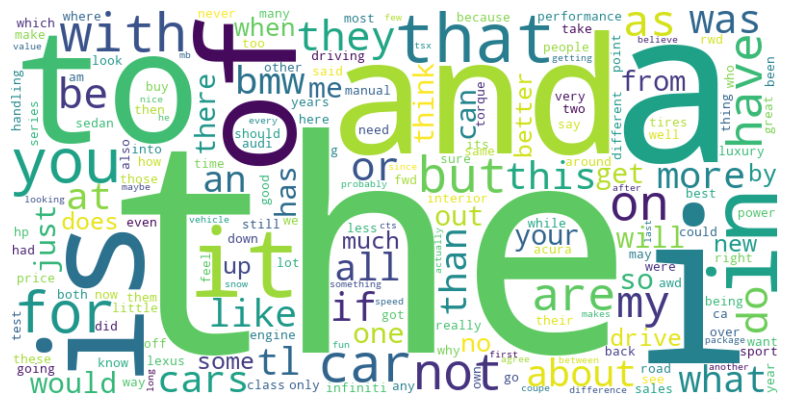

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate a word cloud from the word frequency dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

## Task A Part ii Zipf's law

In [22]:
freq = word_freq_df['frequency'].to_list()

In [24]:
import numpy as np
word_freq_df = word_freq_df.reset_index(drop = True)
word_freq_df.index+=1
word_freq_df['rank'] = word_freq_df.index
word_freq_df['log_rank'] = np.log(word_freq_df['rank'])
word_freq_df['log_freq'] = np.log(word_freq_df['frequency'])
word_freq_df.head()


,word,frequency,rank,log_rank,log_freq
1,the,26298,1,0.000000,10.177248
2,a,12023,2,0.693147,9.394577
3,i,11717,3,1.098612,9.368796
4,and,10569,4,1.386294,9.265680
5,to,9848,5,1.609438,9.195024


In [26]:
import scipy.stats as stats

# Perform log-log transformation
# Perform linear regression on log-log data
slope, intercept, r_value, p_value, std_err = stats.linregress(word_freq_df.iloc[:100]['log_rank'], word_freq_df.iloc[:100]['log_freq'])

# Print the regression results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Generate predicted frequencies according to Zipf's law
# predicted_frequencies = np.exp(intercept) / word_freq_df.iloc[:100]['rank']
predicted_log_frequencies_Zipf = intercept - word_freq_df.iloc[:100]['log_rank']
predicted_log_frequencies = intercept + (slope*word_freq_df.iloc[:100]['log_rank'])

Slope: -0.8888470531509065
Intercept: 10.542505180147646
R-squared: 0.9850590643615029


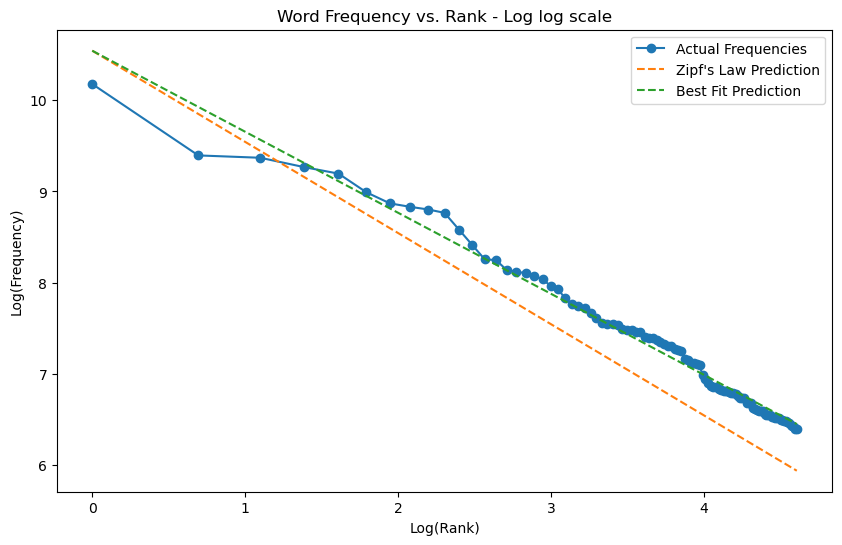

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(word_freq_df.iloc[:100]['log_rank'], word_freq_df.iloc[:100]['log_freq'], label='Actual Frequencies', marker='o')
plt.plot(word_freq_df.iloc[:100]['log_rank'], predicted_log_frequencies_Zipf[:100], label="Zipf's Law Prediction", linestyle='--')
plt.plot(word_freq_df.iloc[:100]['log_rank'], predicted_log_frequencies[:100], label="Best Fit Prediction", linestyle='--')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.title('Word Frequency vs. Rank - Log log scale')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()


In [32]:
n = len(word_freq_df)
print(n)

15273


Reject the null hypothesis: Test Statistic = 251.8770


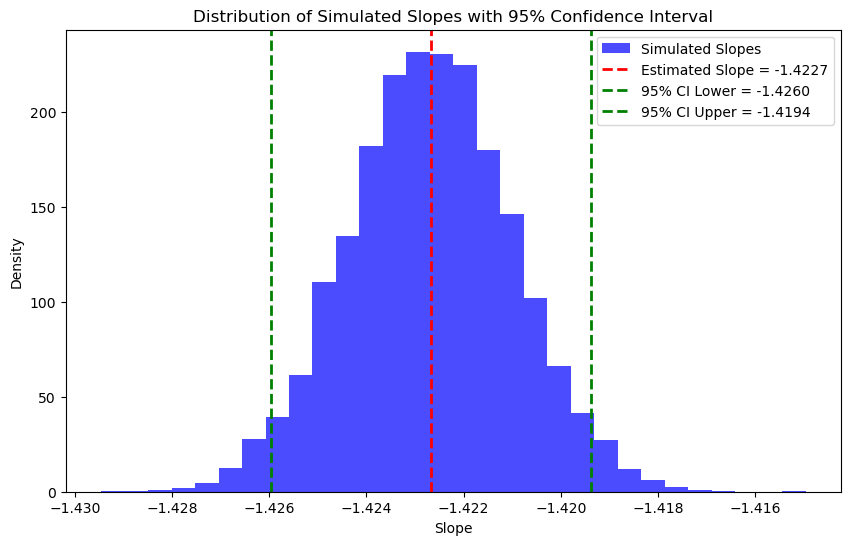

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming word_freq_df is already loaded with 'log_rank' and 'log_freq' columns

# Perform linear regression on log-log data
n = len(word_freq_df)
slope, intercept, r_value, p_value, std_err = stats.linregress(word_freq_df['log_rank'], np.log(word_freq_df['frequency']/n))

# Hypothesis testing: H0: slope = -1
test_statistic = (slope - (-1)) / std_err

# 95% confidence level critical values for a two-tailed test
critical_value = stats.norm.ppf(0.975)  # 1.96 for 95% confidence

# Simulating slope distribution for visualization
n_simulations = 10000  # Number of samples for the simulation
simulated_slopes = np.random.normal(loc=slope, scale=std_err, size=n_simulations)


# Compare the test statistic with the critical value
if np.abs(test_statistic) > critical_value:
    print(f"Reject the null hypothesis: Test Statistic = {abs(test_statistic):.4f}")
else:
    print(f"Fail to reject the null hypothesis: Test Statistic = {test_statistic:.4f}")


# Calculate 95% confidence interval
ci_lower = slope - 1.96 * std_err
ci_upper = slope + 1.96 * std_err


# Plot the distribution of the simulated slopes
plt.figure(figsize=(10, 6))
plt.hist(simulated_slopes, bins=30, density=True, color='blue', alpha=0.7, label='Simulated Slopes')

# Add a vertical line for the estimated slope
plt.axvline(slope, color='red', linestyle='dashed', linewidth=2, label=f'Estimated Slope = {slope:.4f}')

# Add vertical lines for the 95% confidence interval
plt.axvline(ci_lower, color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower = {ci_lower:.4f}')
plt.axvline(ci_upper, color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper = {ci_upper:.4f}')

# Add labels and legend
plt.title('Distribution of Simulated Slopes with 95% Confidence Interval')
plt.xlabel('Slope')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


Hypothesis Test for Slope

We want to test the hypothesis whether the slope of the regression is equal to -1.

 - Null Hypothesis (H₀):  $ \beta = -1 $
 - Alternative Hypothesis (H₁):  $ \beta \neq -1 $

To test this, we calculate the test statistic using the formula:

$$ \text{Test Statistic} = \frac{\hat{\beta} - (-1)}{\text{SE}(\hat{\beta})} $$

where:
 $ \hat{\beta} $  is the estimated slope from the regression.
 $ \text{SE}(\hat{\beta}) $ is the standard error of the slope.

Critical Value and Decision Rule

For a 95% confidence level, the critical values for a two-tailed test from the standard normal distribution are: $ \pm $ 1.96


- If   $|\text{Test Statistic}| > 1.96 $ , we reject the null hypothesis and conclude that the slope is significantly different from -1.
- If   $|\text{Test Statistic}| \leq 1.96 $ , we fail to reject the null hypothesis, meaning there is no sufficient evidence to conclude that the slope is different from -1.

  Here our test statistic is 
$$ \frac{{1.422} - (-1)}{0.00167} = - 251.87 $$
Thus, we reject the null hypothesis with 95% confidence

## Zipf's law is invalidated

## Task B

In [97]:
df_lookup = pd.read_csv('car_models_and_brands.csv')
df_lookup.head()


,Brand,Model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx


In [99]:
df_lookup.iloc[268:272]

,Brand,Model
268,lexus,lexus
269,lincoln,navigator
270,lincoln,town car
271,lincoln,zephyr


### Made some changes to the brand models file - added lexus mapped to lexis; removed car, seat, sedan and problem. These things were impacting results. Lexus was a high occurence brand not showing up in word pairs

In [113]:
import csv
import re
import shutil
from tempfile import NamedTemporaryFile

# Filepaths
output_file = 'replacement_sample_data.csv'  # The file where the modified data will be stored
input_file = 'edmunds_forum_posts_16_sep.csv'               # The file containing the original data
replacement_file = 'car_models_and_brands.csv'   # The file containing original and replacement words

# Create a temporary file to write the changes before moving it to the final location
tempfile = NamedTemporaryFile(mode='w', delete=False, newline='', encoding='utf-8')

def load_replacements(replacement_file):
    """
    Load word replacements from a CSV file into a dictionary.
    The right column contains words to be replaced by the corresponding words in the left column.
    """
    replacements = {}
    with open(replacement_file, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            original, replacement = row[1].lower(), row[0].lower()  # Ensure lowercase comparison
            replacements[original] = replacement
    return replacements

def replace_words_in_text(text, replacements):
    """
    Replace words in the input text according to the replacements dictionary.
    This function ensures that only whole words are replaced.
    """
    # Create a regex pattern for each word in the replacements dictionary.
    pattern = re.compile(r'\b(' + '|'.join(re.escape(word) for word in replacements.keys()) + r')\b', re.IGNORECASE)

    # Function to perform replacement
    def replace_match(match):
        return replacements[match.group(0).lower()]

    # Replace and return modified text
    return pattern.sub(replace_match, text)

def process_file(input_file, output_file, replacements):
    """
    Read the input file, perform word replacements, and write the modified content to the output file.
    """
    with open(input_file, 'r', encoding='utf-8') as infile, tempfile:
        reader = csv.reader(infile)
        writer = csv.writer(tempfile)

        # Iterate over each row in the input CSV file
        for row in reader:
            # Apply the word replacement on each cell of the row
            modified_row = [replace_words_in_text(cell, replacements) for cell in row]
            writer.writerow(modified_row)

    # Replace the original file with the modified file
    shutil.move(tempfile.name, output_file)

def main():
    # Load the replacement words from the replacement CSV file
    replacements = load_replacements(replacement_file)
    
    # Process the input file and apply the replacements
    process_file(input_file, output_file, replacements)

if __name__ == "__main__":
    main()

### Now, a file has been created that has the messages with the model names replaced with brand names

In [115]:
import string
import pandas as pd
import re
from collections import defaultdict
from nltk.corpus import stopwords
import nltk

# Download stopwords from the NLTK package if not already done
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Input and output filenames 
input_filename = 'replacement_sample_data.csv'  # Input file
word_freq_output = 'word_freq.csv'  # Output file for word frequencies
brands_filename = 'car_models_and_brands.csv'  # Brands file

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence, valid_brands):
    """
    Cleans a given sentence by removing punctuation and stopwords, converting text to lowercase,
    and tokenizing the remaining words.
    Keeps only words that are in the valid_brands list.
    """
    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())

    # Tokenize and remove stopwords, keeping only valid brands
    tokens = set([word for word in sentence.split() if word not in stop_words and word in valid_brands])
    
    return tokens

# Extract and clean sentences from the text
def extract_sentences(df, valid_brands):
    """
    Extracts text data from the relevant column, splits it into sentences,
    and cleans each sentence by removing punctuation and stopwords.
    """
    sentences_clean = []
    # Assuming the text is in the last column of the dataframe
    for text in df.iloc[:, -1].dropna():  # Extract text from the last column
        sentences = re.split(r'[.!?]', text)  # Split text into sentences based on punctuation
        for sentence in sentences:
            cleaned_tokens = clean_and_tokenize(sentence, valid_brands)
            if cleaned_tokens:  # Avoid adding empty sentences
                sentences_clean.append(cleaned_tokens)

    return sentences_clean

# Calculate word frequencies
def calculate_word_frequencies(sentences):
    """
    Calculates the frequency of each word in the given list of cleaned sentences.
    """
    word_freq = defaultdict(int)
    for sentence in sentences:
        for word in sentence:
            word_freq[word] += 1

    return word_freq

# Write word frequencies to CSV
def write_word_frequencies(word_freq, output_file):
    """
    Writes the word frequencies to the specified CSV file.
    """
    word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
    word_freq_df.to_csv(output_file, index=False)
    print(f"Word frequencies written to {output_file}")


# Step 1: Load and preprocess data
brands_df = pd.read_csv(brands_filename)  # Load brands
valid_brands = set(brands_df['Brand'].str.lower())  # Create a set of valid brand names

df = pd.read_csv(input_filename)  # Load the input file

# Step 2: Extract and clean sentences
sentences = extract_sentences(df, valid_brands)
# print(sentences[:4])

# Step 3: Calculate word frequencies
word_freq = calculate_word_frequencies(sentences)
# print(word_freq['lexus'])

# Step 4: Write word frequencies to CSV
write_word_frequencies(word_freq, word_freq_output)


Word frequencies written to word_freq.csv


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Following are the top brands 

In [116]:
df_word_freq = pd.read_csv('word_freq.csv')
df_word_freq.sort_values(by = 'Frequency', ascending = False)[:10]
# df_word_freq.head()

,Word,Frequency
1,bmw,2311
3,acura,737
0,audi,645
12,honda,563
6,infiniti,506
7,lexus,442
13,nissan,394
10,toyota,373
19,subaru,320
15,volkswagen,269


## Task C

In [120]:
top_brands = df_word_freq.sort_values(by = 'Frequency', ascending = False)[:10]['Word'].to_list()
left = []
right = []
for i in range(0, len(top_brands)):
    for j in range(i+1, len(top_brands)):
        left.append(top_brands[i])
        right.append(top_brands[j])


In [122]:
top_brands

['bmw',
 'acura',
 'audi',
 'honda',
 'infiniti',
 'lexus',
 'nissan',
 'toyota',
 'subaru',
 'volkswagen']

In [124]:
df_combo = pd.DataFrame(columns = ['brand_1','brand_2'])
df_combo['brand_1'] = left
df_combo['brand_2'] = right
df_combo.head()

,brand_1,brand_2
0,bmw,acura
1,bmw,audi
2,bmw,honda
3,bmw,infiniti
4,bmw,lexus


In [126]:
df_combo.shape

(45, 2)

In [128]:
df_combo.to_csv('word_pairs.csv')

In [134]:
from collections import defaultdict
from itertools import combinations

df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])  # To store lift values
word_frequency = {}  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(dict)  # Dictionary to store word pair co-occurrence frequency
file_length = 0  # Number of rows in the input file
MAX_DISTANCE = 5  # Max distance (in words) between brand mentions for lift calculation

# File paths
input_file = 'replacement_sample_data.csv'  # Input data file
pair_keys_file = 'word_pairs.csv'  # File containing the words to calculate lift
output_lift_values = 'Lift_Values.csv'  # Output file for lift values


# Function to clean and tokenize text (removes punctuation and stopwords)
def clean_text(text):
    """
    Cleans a given text by removing punctuation, converting it to lowercase,
    and tokenizing it, ignoring any stopwords.
    """
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text.lower())  # Remove punctuation
    tokens = [word for word in text.split() if word not in stop_words]  # Tokenize and remove stopwords
    return tokens

# Step 1: Load the words from the word_pairs.csv file and generate all pairs
def load_word_pairs(filename):
    """
    Loads words from a file where words are comma-separated in each row.
    Skips the header row.
    Returns a list of all possible word pairs for each row.
    """
    word_pairs = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            # print (row)
            words = [word.strip() for word in row[1:]]  # Clean each word
            if len(words) >= 2:  # Ensure there are at least 2 words to form pairs
                word_pairs.extend(combinations(words, 2))
    return word_pairs

# Step 2: Process the input CSV file to extract posts and clean the text
def process_input_file(input_filename):
    """
    Processes the input CSV file to extract and clean posts. Each post is tokenized,
    cleaned of punctuation and stopwords, and stored in a list.
    """
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        next(reader) # Skip the header row
        for row in reader:
            post_text = ' '.join(row[1:])  # Combine all columns into one string
            cleaned_post = clean_text(post_text)  # Clean and tokenize the post
            if cleaned_post:
                posts.append(cleaned_post)
    return posts

# Step 3: Calculate word frequencies and word pair co-occurrences
def calculate_frequencies(posts, max_distance=MAX_DISTANCE):
    """
    Calculates the frequency of individual words and word pairs within the posts.
    Updates the global word_frequency and word_pair_frequency dictionaries.
    Only counts word pairs that appear within a specified distance (number of words).
    """
    global word_frequency, word_pair_frequency

    for post in posts:
        unique_words = set(post)  # Track unique words in the post to avoid double counting
        # Count word frequencies
        for word in unique_words:
            word_frequency[word] = word_frequency.get(word, 0) + 1

        # Count word pair co-occurrences within the max_distance
        for i, word1 in enumerate(post):
            for j in range(i + 1, len(post)):
                word2 = post[j]
                if word1 != word2 and (j - i) <= max_distance:
                    word_pair_frequency[word1][word2] = word_pair_frequency[word1].get(word2, 0) + 1
                    word_pair_frequency[word2][word1] = word_pair_frequency[word2].get(word1, 0) + 1


        for j in range(len(post) - 1, 0, -1):  # Start from the end and move towards the start
            word2 = post[i]
            for i in range(i - 1, -1, -1):  # Iterate backwards from i
                word1 = post[j]
                if word1 != word2 and abs(j - i) <= max_distance:  # Adjusted condition for reverse traversal
                    word_pair_frequency[word2][word1] = word_pair_frequency[word2].get(word1, 0) + 1
                    word_pair_frequency[word2][word1] = word_pair_frequency[word2].get(word1, 0) + 1
                    
                # print(file_length, word1, word2, word_frequency.get(word1, 0),word_frequency.get(word2, 0) , max(word_pair_frequency[word1].get(word2, 0),word_pair_frequency[word2].get(word1, 0)))

# Step 4: Calculate the lift between word pairs
def calculate_lift(word_pairs):
    """
    Calculates the lift between word pairs using the formula:
    Lift(word1, word2) = P(word1 AND word2) / (P(word1) * P(word2))
    Lift is written to the lift values CSV and stored in a DataFrame for further processing.
    Only include word pairs where word1 < word2 lexicographically to ensure an upper triangular matrix.
    """
    global word_frequency, word_pair_frequency, df_lift, file_length

    rows_to_add = []
    for word1, word2 in word_pairs:
        # Calculate probabilities
        
        p_word1 = word_frequency.get(word1, 0) / file_length
        p_word2 = word_frequency.get(word2, 0) / file_length
        p_word1_and_word2 = word_pair_frequency[word1].get(word2, 0) / file_length
        # print(word1, word2, (word_pair_frequency[word1].get(word2, 0),word_pair_frequency[word2].get(word1, 0)))

        if p_word1 > 0 and p_word2 > 0:  # Ensure probabilities are valid
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            rows_to_add.append({'word1': word1, 'word2': word2, 'lift_value': lift_value})

    # Use pd.concat to append all rows at once to df_lift
    df_lift = pd.concat([df_lift, pd.DataFrame(rows_to_add)], ignore_index=True)
    # print(df_lift)

# Step 5: Write lift values and matrix to CSV
def save_results():
    """
    Writes the calculated lift values to a CSV file and also generates a lift matrix,
    saving it to another CSV.
    Ensures the matrix is upper triangular.
    """
    global df_lift

    # Save the lift values DataFrame to CSV
    df_lift.to_csv(output_lift_values, index=False)

    


global file_length
# Load word pairs
word_pairs = load_word_pairs(pair_keys_file)
# print(word_pairs[:5])

# Process the input file and get posts
posts = process_input_file(input_file)
file_length = len(posts)
# print(posts[4:5])

# Calculate word frequencies and pair co-occurrences
calculate_frequencies(posts)
# print(word_pair_frequency['bmw']['acura'])

# Calculate lift for word pairs
calculate_lift(word_pairs)

# Save results
save_results()


/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_1544/2475639584.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lift = pd.concat([df_lift, pd.DataFrame(rows_to_add)], ignore_index=True)


### Important notes on methodology
* Maximum distance allowed between two words, to be considered for co-occurence is 5
* Multiple mentions of a brand in a sentence have been counted only once (implemented using the set function)
* Co-occurences values are stored in a dictionary of dictionaries. If audi and bmw co-occur, then both, values corresponding to bmw -> audi and audi -> bmw are incremented by 1 thus maintaining symmetry

In [140]:
import numpy as np
df_lift = pd.read_csv('Lift_Values.csv')
# Step 1: Extract unique brand names
unique_brands = pd.unique(df_lift[['word1', 'word2']].values.ravel('K'))[:10]  # Get unique brands and limit to 10

# Step 2: Create an empty DataFrame with brand names as rows and columns
lift_matrix_10x10 = pd.DataFrame(np.nan, index=unique_brands, columns=unique_brands)

# Step 3: Populate the upper triangular matrix
for _, row in df_lift.iterrows():
    # print(row)
    word1 = row['word1']
    word2 = row['word2']
    lift_value = row['lift_value']
    
    if word1 in unique_brands and word2 in unique_brands:
        lift_matrix_10x10.loc[word1, word2] = lift_value
        # if word1 < word2:  # Ensure it's upper triangular
            

# Display the lift matrix
lift_matrix_10x10.fillna('')

,bmw,acura,audi,honda,infiniti,lexus,nissan,toyota,subaru,volkswagen
bmw,,0.701272,1.276166,0.379952,1.348801,1.450453,0.248414,0.43797,0.452556,0.470525
acura,,,1.285077,1.373514,2.053001,1.823772,0.735212,0.20201,1.052383,0.2842
audi,,,,0.381604,1.517225,1.055622,0.415823,0.444318,0.75754,3.600542
honda,,,,,0.774918,0.329375,2.883227,4.289051,0.61554,0.658266
infiniti,,,,,,2.852991,1.023525,0.246074,1.04886,0.166172
lexus,,,,,,,0.299093,1.495673,0.245197,0.291352
nissan,,,,,,,,3.02136,0.536591,0.743862
toyota,,,,,,,,,0.258012,1.124124
subaru,,,,,,,,,,1.016366
volkswagen,,,,,,,,,,


## Task D

In [154]:
# Step 4: Create the MDS matrix by applying 1 / lift_value to the upper triangular part
mds_matrix = pd.DataFrame(np.nan, index=unique_brands, columns=unique_brands)

for word1 in unique_brands:
    for word2 in unique_brands:
        if word1 != word2 and pd.notna(lift_matrix_10x10.loc[word1, word2]):
            mds_matrix.loc[word1, word2] = 1 / lift_matrix_10x10.loc[word1, word2]

# Display the MDS matrix
mds_matrix.fillna('')

,bmw,acura,audi,honda,infiniti,lexus,nissan,toyota,subaru,volkswagen
bmw,,1.42598,0.783597,2.631914,0.741399,0.68944,4.025538,2.28326,2.20967,2.125284
acura,,,0.778163,0.72806,0.487092,0.548314,1.360151,4.950261,0.950224,3.518652
audi,,,,2.620521,0.659098,0.947308,2.404867,2.250642,1.320063,0.277736
honda,,,,,1.290459,3.036051,0.346834,0.233152,1.624589,1.519142
infiniti,,,,,,0.350509,0.977016,4.063819,0.953416,6.01785
lexus,,,,,,,3.343442,0.668595,4.078353,3.432277
nissan,,,,,,,,0.330977,1.863618,1.344336
toyota,,,,,,,,,3.875786,0.889582
subaru,,,,,,,,,,0.983898
volkswagen,,,,,,,,,,


#### Normalized MDS matrix

In [160]:

# Step 1: Calculate the maximum value, ignoring NaNs
max_value = np.nanmax(mds_matrix.values)

# Step 2: Normalize the matrix by dividing by the maximum value, ignoring NaNs
mds_matrix_normalized = mds_matrix.map(lambda x: x / max_value if pd.notna(x) else np.nan)

# Step 3: Fill NaNs with empty strings if desired for display purposes
mds_matrix_normalized.fillna('')


,bmw,acura,audi,honda,infiniti,lexus,nissan,toyota,subaru,volkswagen
bmw,,0.236958,0.130212,0.437351,0.1232,0.114566,0.668933,0.379415,0.367186,0.353163
acura,,,0.129309,0.120983,0.080941,0.091115,0.226019,0.822596,0.157901,0.584703
audi,,,,0.435458,0.109524,0.157416,0.399622,0.373994,0.219358,0.046152
honda,,,,,0.214439,0.504508,0.057634,0.038743,0.269962,0.252439
infiniti,,,,,,0.058245,0.162353,0.675294,0.158431,1.0
lexus,,,,,,,0.555587,0.111102,0.677709,0.570349
nissan,,,,,,,,0.054999,0.309682,0.223391
toyota,,,,,,,,,0.644048,0.147824
subaru,,,,,,,,,,0.163497
volkswagen,,,,,,,,,,


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


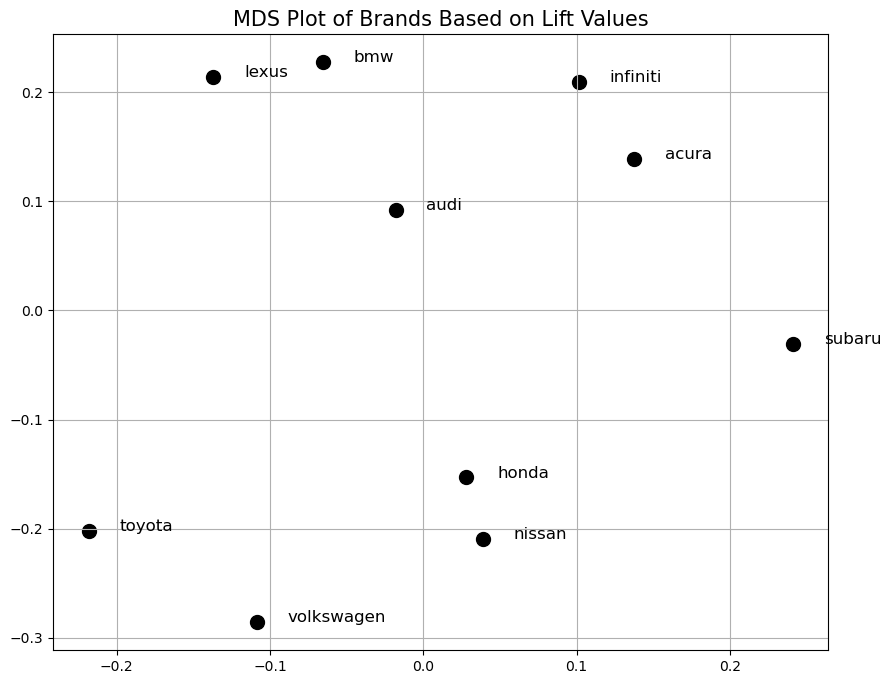

In [166]:

import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Assuming `mds_matrix` is already computed as the reciprocal of lift values

# Step 1: Ensure symmetry by copying the upper triangular values to the lower triangular part
mds_matrix_symmetric = mds_matrix_normalized.copy()

# Fill NaN values to ensure symmetry
mds_matrix_symmetric = mds_matrix_symmetric.fillna(1e6)  # Large value for undefined distances

# Ensure the matrix is symmetric by filling in the lower triangular part
for i in range(len(mds_matrix_symmetric)):
    for j in range(i+1, len(mds_matrix_symmetric)):
        mds_matrix_symmetric.iloc[j, i] = mds_matrix_symmetric.iloc[i, j]

# Step 2: Apply MDS to reduce the distance matrix to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(mds_matrix_symmetric)

# Step 3: Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(mds_result[:, 0], mds_result[:, 1], s=100, color='black')

# Step 4: Annotate the points with brand names
for i, brand in enumerate(mds_matrix_symmetric.index):
    plt.text(mds_result[i, 0] + 0.02, mds_result[i, 1], brand, fontsize=12)

# Step 5: Customize plot
plt.title('MDS Plot of Brands Based on Lift Values', fontsize=15)
plt.grid(True)

# Show the plot
plt.show()

### Task E

### Task F

#### 5 most frequenctly metioned attributes of cars in the discussion

In [171]:

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Load the stopwords
stop_words = set(stopwords.words('english'))

# Load your CSV file
df = pd.read_csv('edmunds_forum_posts_16_sep.csv')
df.columns = ['date','message']
df = df.dropna()

# Function to tokenize words, remove punctuation, and filter out stopwords
def tokenize_text(text):
    tokens = word_tokenize(text)
    # Remove punctuation, convert to lowercase, and filter out stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

# Apply the tokenization function to the 'message' column
df['tokens'] = df['message'].apply(tokenize_text)

# Flatten the list of tokens and calculate word frequencies
all_tokens = [word for tokens_list in df['tokens'] for word in tokens_list]
word_freq = Counter(all_tokens)

# Convert to DataFrame for better readability
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### These are the top identified attributes of cars

In [173]:
# Corrected filter for specific words in the 'word' column
filtered_word_freq_df = word_freq_df[word_freq_df['word'].isin(['performance', 'luxury', 'engine', 'power', 'interior', 'handling', 'hp', 'look', 'tires', 'torque'])]
filtered_word_freq_df[:5]

,word,frequency
2,performance,896
3,luxury,681
167,engine,609
283,power,492
127,interior,486


In [174]:
attributes = filtered_word_freq_df['word'][:5].to_list()

In [175]:

left = []
right = []
for i in range(0, len(top_brands)):
    for j in range(0, len(attributes)):
        left.append(top_brands[i])
        right.append(attributes[j])

df_attr_brand = pd.DataFrame(columns = ['brand','attribute'])
df_attr_brand['brand'] = left
df_attr_brand['attribute'] = right
df_attr_brand.head()

,brand,attribute
0,bmw,performance
1,bmw,luxury
2,bmw,engine
3,bmw,power
4,bmw,interior


In [176]:
df_attr_brand.shape

(50, 2)

In [182]:
df_attr_brand.to_csv('df_attr_brand.csv')
brand_attr_pairs = load_word_pairs('df_attr_brand.csv')

df_lift_brand_attr = pd.DataFrame(columns=['brand', 'attribute', 'lift_value']) 
def calculate_lift2(word_pairs):
    """
    Calculates the lift between word pairs using the formula:
    Lift(word1, word2) = P(word1 AND word2) / (P(word1) * P(word2))
    Lift is written to the lift values CSV and stored in a DataFrame for further processing.
    Only include word pairs where word1 < word2 lexicographically to ensure an upper triangular matrix.
    """
    global word_frequency, word_pair_frequency, df_lift_brand_attr, file_length

    rows_to_add = []
    for word1, word2 in word_pairs:
        # Calculate probabilities
        p_word1 = word_frequency.get(word1, 0) / file_length
        p_word2 = word_frequency.get(word2, 0) / file_length
        p_word1_and_word2 = (word_pair_frequency[word1].get(word2, 0)+word_pair_frequency[word2].get(word1, 0)) / file_length

        if p_word1 > 0 and p_word2 > 0:  # Ensure probabilities are valid
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            rows_to_add.append({'brand': word1, 'attribute': word2, 'lift_value': lift_value})

    # Use pd.concat to append all rows at once to df_lift
    df_lift_brand_attr = pd.concat([df_lift_brand_attr, pd.DataFrame(rows_to_add)], ignore_index=True)
    return df_lift_brand_attr


calculate_lift2(brand_attr_pairs).to_csv('df_lift_brand_attr.csv')

/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_1544/3092349902.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lift_brand_attr = pd.concat([df_lift_brand_attr, pd.DataFrame(rows_to_add)], ignore_index=True)


In [184]:
df_lift_brand_attr.pivot(index='brand', columns='attribute')

lift_value                                          
attribute      engine  interior    luxury performance     power
brand                                                          
acura        0.466801  0.468499  1.115796    0.617431  1.139992
audi         1.416880  1.468403  0.765704    0.692596  0.644760
bmw          1.030458  0.646378  0.545402    0.851856  0.770362
honda        0.660739  1.054999  1.263493    0.357525  0.419121
infiniti     0.545880  1.369663  0.913372    0.361013  0.793519
lexus        0.558307  0.600361  1.143875    0.421979  0.649267
nissan       0.610901  1.532806  0.667537    0.404014  1.014900
subaru       0.715454  1.645545  4.332381    1.577199  1.248025
toyota       0.503560  0.631739  1.604880    0.832563  1.268802
volkswagen   0.566752  1.777540  1.219237    0.655929  0.988632

In [186]:
df_lift_brand_attr[df_lift_brand_attr['lift_value']>1.5]

,brand,attribute,lift_value
34,nissan,interior,1.532806
36,toyota,luxury,1.604880
40,subaru,performance,1.577199
41,subaru,luxury,4.332381
44,subaru,interior,1.645545
49,volkswagen,interior,1.777540


### Task G

Key Observations (Note that the posts analysed are from 2002 to 2006):

 * **Subaru’s unique position on the MDS plot**: This reflects that Subaru was being perceived quite distinctly from other brands, which could signify its differentiation strategy or how it was viewed by customers in terms of attributes such as performance, luxury, and interior. It stands apart from other entry-level luxury performance brands.
 * **High lift values for performance, luxury, and interior**: These three attributes suggest that during the early 2000s, Subaru had some competitive edge or significant recognition in these areas among enthusiasts discussing on Edmunds. This aligns with their vehicles’ appeal to customers who valued performance and practical interior designs.

Analyzing Subaru's strategic decisions retrospectively:

Subaru’s marketing strategy over the years reflects a clear shift towards promoting affordability, safety, and practicality, rather than luxury or high-end performance. Some key marketing campaigns that highlight this repositioning:

* **“Love. It’s What Makes a Subaru, a Subaru” Campaign**: Launched in 2008, this campaign shifted the focus to themes of love, safety, and family, which helped Subaru align itself with customers seeking reliable and affordable vehicles. The campaign emphasized Subaru’s core strengths, such as all-wheel drive, safety ratings, and reliability, appealing to practical buyers rather than luxury-seeking consumers.
* **“Dog Tested, Dog Approved” Campaign**: Subaru began marketing heavily to families and pet owners, aligning their brand with adventurous, practical, and family-oriented consumers rather than those seeking luxury. This campaign further reinforced Subaru’s identity as a brand for outdoor enthusiasts and families with active lifestyles.
* **“Share the Love” Event**: Introduced in 2007, this annual campaign involved Subaru donating a portion of sales to charities chosen by buyers. This not only solidified Subaru’s image as an affordable, community-focused brand but also further distanced itself from luxury brands, which typically focus on exclusivity rather than community-driven values.

   Subaru didn’t aggressively push into the luxury and performance persona, despite the high lift values in luxury attributes from the 2000s discussions. Brands like Audi and Lexus solidified their positions, while Subaru chose to solidify their mid-market appeal. They concentrated on enhancing the interior quality of their more mass-market vehicles, but without pursuing the full luxury brand transformation.


### This conscious shift in positioning becomes even more evident when we look at Subaru's relative positioning using the MDS plot from the latest 5000 posts available

![alt text](New_MDS_plot.png "MDS based on latest 5000 posts")

We believe that Subaru missed a significant opportunity by not capitalizing on its early intersection of luxury and performance perceptions, particularly in the entry-level luxury car market. This was indeed a missed chance because, if we consider the number of mentions of Subaru as a measure of popularity and potential sales, the brand has seen a noticeable decline in visibility. Furthermore, Subaru's association with the attribute "luxury" has diminished drastically—its lift value for luxury is now less than a quarter of what it was in the 2002-2006 period, based on the forum posts. This suggests that Subaru’s potential to compete in the luxury space faded as it shifted towards a more affordable, practical image.

### Recommendation

### Task H

In [228]:
import csv
import re
import shutil
from tempfile import NamedTemporaryFile

# Filepaths
output_file = 'replacement_sample_data_aspiration.csv'  # The file where the modified data will be stored
input_file = 'replacement_sample_data.csv'               # The file containing the original data
replacement_file = 'aspiration_replacement_new.csv'   # The file containing original and replacement words

# Create a temporary file to write the changes before moving it to the final location
tempfile = NamedTemporaryFile(mode='w', delete=False, newline='', encoding='utf-8')

def load_replacements(replacement_file):
    """
    Load word replacements from a CSV file into a dictionary.
    The right column contains words to be replaced by the corresponding words in the left column.
    """
    replacements = {}
    with open(replacement_file, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            original, replacement = row[0].lower(), row[1].lower()  # Ensure lowercase comparison
            replacements[original] = replacement
    return replacements

def replace_words_in_text(text, replacements):
    """
    Replace words in the input text according to the replacements dictionary.
    This function handles unigrams, bigrams, and trigrams.
    """
    # Sort the keys of the replacements by length (to prioritize bigrams/trigrams over unigrams)
    sorted_replacements = sorted(replacements.keys(), key=lambda x: len(x.split()), reverse=True)

    # Create a regex pattern for each word/phrase in the replacements dictionary
    pattern = re.compile(r'\b(' + '|'.join(re.escape(phrase) for phrase in sorted_replacements) + r')\b', re.IGNORECASE)

    # Function to perform replacement
    def replace_match(match):
        return replacements[match.group(0).lower()]

    # Replace and return modified text
    return pattern.sub(replace_match, text)

def process_file(input_file, output_file, replacements):
    """
    Read the input file, perform word replacements, and write the modified content to the output file.
    """
    with open(input_file, 'r', encoding='utf-8') as infile, tempfile:
        reader = csv.reader(infile)
        writer = csv.writer(tempfile)

        # Iterate over each row in the input CSV file
        for row in reader:
            # Apply the word replacement on each cell of the row
            modified_row = [replace_words_in_text(cell, replacements) for cell in row]
            writer.writerow(modified_row)

    # Replace the original file with the modified file
    shutil.move(tempfile.name, output_file)


# Load the replacement words from the replacement CSV file
replacements = load_replacements(replacement_file)

# Process the input file and apply the replacements
process_file(input_file, output_file, replacements)

In [256]:

import re
asp_words = pd.read_csv('aspiration_replacement_new.csv')

# List of unigrams, bigrams, and trigrams
phrases = asp_words['Original Phrase'].to_list()

# Function to count the occurrences of a word/phrase in the DataFrame's Message column
def count_occurrences(df, word):
    return df['Message'].str.count(r'\b' + re.escape(word) + r'\b', flags=re.IGNORECASE).sum()

# Load the CSV file
file_path = 'replacement_sample_data.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Count occurrences for each phrase
phrase_occurrences = {phrase: count_occurrences(df, phrase) for phrase in phrases}
phrase_count_df = pd.DataFrame(columns = ['phrase','type','count'])

# Print out the counts
for phrase, count in phrase_occurrences.items():
    new_row = pd.DataFrame({
        'phrase': [phrase],
        'type': [len(phrase.split())],  # Length of the split phrase (1 = unigram, 2 = bigram, 3 = trigram)
        'count': [count]
    })
    
    # Concatenate the new row with the existing DataFrame
    phrase_count_df = pd.concat([phrase_count_df, new_row], ignore_index=True)


/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_1544/3000953703.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  phrase_count_df = pd.concat([phrase_count_df, new_row], ignore_index=True)


In [268]:
phrase_count_df.groupby(['type']).agg({'count':'sum'})/file_length

,count
type,
1,0.062575
2,0.006217
3,0.002206


In [289]:
import pandas as pd



df = pd.read_csv('replacement_sample_data_aspiration.csv')
# Function to count the co-occurrence of two words (both appearing in the same message)
def count_co_occurrences(df, word1, word2):
    return df[df['Message'].str.contains(r'\b' + word1 + r'\b', flags=re.IGNORECASE) &
              df['Message'].str.contains(r'\b' + word2 + r'\b', flags=re.IGNORECASE)].shape[0]

# Get the total number of messages
total_messages = df.shape[0]

# Count occurrences of "aspiration"
aspiration_count = count_occurrences(df, 'aspiration')

# Calculate the lift for each brand
lift_values = {}

for brand in top_brands:
    # Count occurrences of the brand
    brand_count = count_occurrences(df, brand)
    
    # Count co-occurrence of the brand and "aspiration"
    co_occurrence_count = count_co_occurrences(df, brand, 'aspiration')
    
    # Calculate probabilities
    P_brand = brand_count / total_messages
    P_aspiration = aspiration_count / total_messages
    P_co_occurrence = co_occurrence_count / total_messages
    
    # Calculate lift (handling cases where P_brand or P_aspiration is zero)
    if P_brand > 0 and P_aspiration > 0:
        lift = P_co_occurrence / (P_brand * P_aspiration)
    else:
        lift = 0
    
    # Store the lift value for the brand
    lift_values[brand] = lift

lift_df = pd.DataFrame(columns = ['brand','lift'])

# Display the lift values
for brand, lift in lift_values.items():
    new_row = pd.DataFrame({
        'brand': [brand],
        'lift': [lift]
    })
    
    # Concatenate the new row with the existing DataFrame
    lift_df = pd.concat([lift_df, new_row], ignore_index=True)

lift_df_sorted = lift_df.sort_values(by='lift', ascending=False)



/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_1544/3577253246.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lift_df = pd.concat([lift_df, new_row], ignore_index=True)


In [291]:
import matplotlib.pyplot as plt

In [301]:
# Display the sorted DataFrame

lift_df_sorted

,brand,lift
4,infiniti,1.231143
7,toyota,1.052399
5,lexus,0.996510
3,honda,0.914042
6,nissan,0.821236
9,volkswagen,0.795932
1,acura,0.755876
0,bmw,0.660691
2,audi,0.509682
8,subaru,0.474797


<Figure size 1000x600 with 0 Axes>

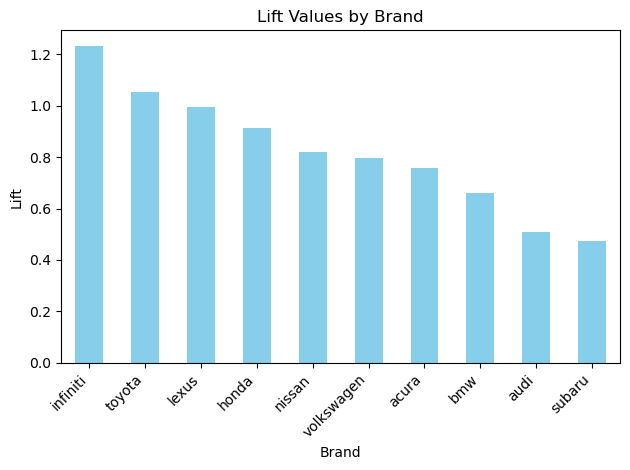

In [305]:
import matplotlib.pyplot as plt

# Assuming lift_df_sorted is already defined and sorted
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size for readability

# Plot the lift values as a bar chart with 'Brand' on the x-axis
lift_df_sorted.plot(
    x='brand', 
    y='lift', 
    kind='bar', 
    legend=False, 
    color='skyblue'
)

# Customize the x-axis label and rotate the brand names for readability
plt.xlabel('Brand')
plt.ylabel('Lift')
plt.title('Lift Values by Brand')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()